# Ensemble of models with NO PET as input ...

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")

%load_ext autoreload 
%autoreload 2

In [2]:
from scripts.read_nh_results import (
    read_multi_experiment_results,
    calculate_member_errors
)

In [3]:
data_dir = Path("/datadrive/data")
run_dir = data_dir / "runs/ensemble_NO_EVAP"

In [4]:
if not (run_dir / "member_ds.nc").exists():
    member_ds = read_multi_experiment_results(ensemble_dir=run_dir, ensemble_members=True)
    member_ds.to_netcdf(run_dir / "member_ds.nc")

else:
    member_ds = xr.open_dataset(run_dir / "member_ds.nc")


In [5]:
if not (run_dir / "member_errors.nc").exists():
    member_errors = calculate_member_errors(
        member_ds, 
        basin_coord="station_id", 
        time_coord="time", 
        obs_var="obs",
        sim_var="sim",
        metrics=["NSE", "KGE", "Pearson-r", "FHV", "FMS", "FLV",]
    )
    member_errors.to_netcdf(run_dir / "member_errors.nc")
else:
    member_errors = xr.open_dataset(run_dir / "member_errors.nc")

In [6]:
min_ = member_ds.min(dim=["member"])
max_ = member_ds.max(dim=["member"])
median_ = member_ds.median(dim=["member"])

### calculate median error

In [7]:
from scripts.read_nh_results import calculate_all_error_metrics

if not (run_dir / "med_errors.nc").exists():
    med_errors = calculate_all_error_metrics(preds=median_, basin_coord="station_id", time_coord="time", obs_var="obs", sim_var="sim")
    med_errors.to_netcdf(run_dir / "med_errors.nc")
else:
    med_errors = xr.open_dataset(run_dir / "med_errors.nc")
    
med_errors

<xarray.Dataset>
Dimensions:      (station_id: 667)
Coordinates:
  * station_id   (station_id) int64 10002 10003 1001 ... 96002 96004 97002
Data variables:
    Alpha-NSE    (station_id) float64 ...
    Beta-NSE     (station_id) float64 ...
    FHV          (station_id) float64 ...
    FLV          (station_id) float64 ...
    FMS          (station_id) float64 ...
    KGE          (station_id) float64 ...
    MSE          (station_id) float64 ...
    NSE          (station_id) float64 ...
    Peak-Timing  (station_id) float64 ...
    Pearson-r    (station_id) float64 ...
    RMSE         (station_id) float64 ...

# Check the hydrographs

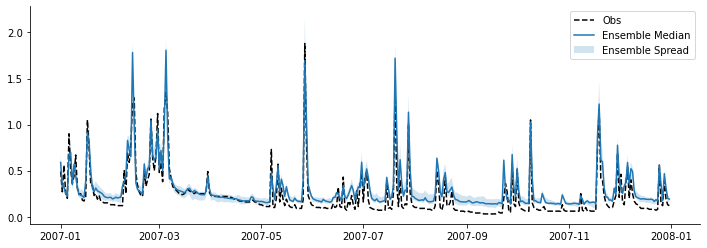

In [8]:
time = "2007"
choices = np.random.choice(member_ds.station_id.values, 3)

px = choices[0]

f, ax = plt.subplots(figsize=(12, 4))
md = median_.sel(station_id=px, time=time).to_dataframe()
mn = min_.sel(station_id=px, time=time).to_dataframe()
mx = max_.sel(station_id=px, time=time).to_dataframe()
ax.plot(md.index, md["obs"], color="k", ls="--", label="Obs")
ax.plot(md.index, md["sim"], color="C0", label="Ensemble Median")
ax.fill_between(md.index, mn["sim"], mx["sim"], label="Ensemble Spread", alpha=0.2)
ax.legend()
sns.despine()

# where is the uncertainty highest?
# How does it compare to the w/evap model?

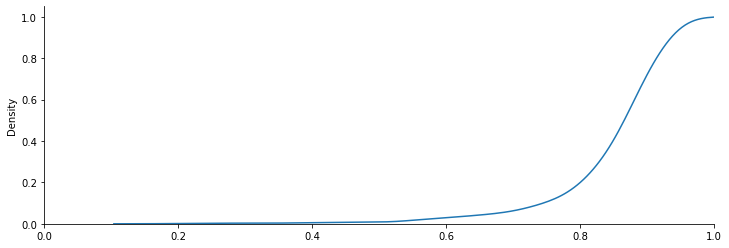

In [9]:
from scripts.cell_state.analysis import finite_flat

x = finite_flat(med_errors["NSE"].values)
f, ax = plt.subplots(figsize=(12, 4))
sns.kdeplot(x, cumulative=True, ax=ax)
ax.set_xlim(0, 1)
sns.despine()
# n, bins, patches = ax.hist(x, bins=100, density=True, histtype='stepfilled', cumulative=True, label='Empirical', alpha=0.6)

In [13]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points

In [22]:
points = load_latlon_points(data_dir=Path("/home/tommy/spatio_temporal/data"))

In [23]:
gdf = gpd.GeoDataFrame(med_errors["NSE"].to_dataframe().join(points))

,NSE,geometry
station_id,,
10002,0.887003,POINT (-1.83000 57.53000)
10003,0.904075,POINT (-2.09000 57.36000)
1001,0.851324,POINT (-3.27000 58.48000)
101002,0.738369,POINT (-1.29000 50.69000)
101005,0.803517,POINT (-1.25000 50.65000)
...,...,...
95001,0.881613,POINT (-5.15000 58.17000)
96001,0.849470,POINT (-3.90000 58.48000)
96002,0.903619,POINT (-4.21000 58.48000)


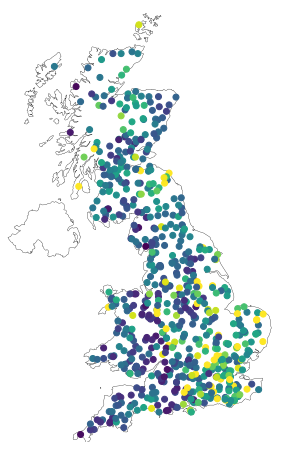

In [26]:
ax = initialise_gb_spatial_plot()
gdf.plot("NSE", ax=ax, vmin=0.7, cmap="viridis_r");